In [1]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.1-cp27-cp27mu-linux_x86_64.whl 
!pip install torchvision 




# Don't forget to enable GPU :It is so simple to alter default hardware (CPU to GPU or vice versa); just follow Edit > Notebook settings or Runtime>Change runtime type and select GPU as Hardware accelerator.
# source: Deep Learning Turkey

    100% |████████████████████████████████| 496.9MB 66.8MB/s 
    100% |████████████████████████████████| 51kB 2.9MB/s 
    100% |████████████████████████████████| 5.9MB 198kB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
# Import various modules, including those for image preprocessing 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from numpy.linalg import inv
from collections import OrderedDict
from operator import itemgetter
import string
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import time
import cv2 
import cv2 as cv
import scipy.misc

# Import pytorch modules
import pickle as pkl
import torch 
import numpy as np
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [55]:
#Load data from Instructor kaggle http address

start_time = time.time()
print('start...')

URL_ENDPOINT = "http://cs.mcgill.ca/~ksinha4/datasets/kaggle/"

x = np.loadtxt(URL_ENDPOINT+"train_x.csv", delimiter=",")
y = np.loadtxt(URL_ENDPOINT+"train_y.csv", delimiter=",")
xTest = np.loadtxt(URL_ENDPOINT+"test_x.csv", delimiter=",")


print("Loaded data in --- %s seconds ---" % (time.time() - start_time))

start...
Loaded data in --- 763.034366131 seconds ---


In [0]:
x = x.reshape(-1, 64, 64) # reshape 
y = y.reshape(-1, 1) 
xTest = xTest.reshape(-1,64,64)

In [57]:
# recast type (takes less memory)

x     = x.astype(np.uint8);
xTest = xTest.astype(np.uint8);
print(y.shape)
print(x.shape)
print(xTest.shape)

(50000, 1)
(50000, 64, 64)
(10000, 64, 64)


In [58]:
from sys import getsizeof   # return size of object in bytes
def getSizeX(a):
    print(a.size * a.dtype.itemsize * 1e-9)

getSizeX(x);

0.2048


In [59]:
# Image preprocessing (now reduced to 32 x 32 instead of 64 x 64)


def returnBiggestContour(image):
    thresh = np.array(image,dtype='uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)
    sizes = stats[:, -1]
    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255.
    tx = 32 - centroids[max_label][0];
    ty = 32 - centroids[max_label][1];
    M = np.float32([[1,0,tx],[0,1,ty]])
    dst = cv.warpAffine(img2,M,(64,64))
    return dst

def compareDatasets(x,xProcessed):
    for i in range(x.shape[0]):
        plt.subplot(131),plt.imshow(x[i],cmap = 'gray')
        plt.title('Original Image'), plt.xticks([]), plt.yticks([]);
        plt.subplot(132),plt.imshow(xProcessed[i],cmap = 'gray')
        plt.title('Processed Image'), plt.xticks([]), plt.yticks([]);
        plt.show();

        

def preProcessData(x):
    start_time = time.time()
    xProcessed = np.zeros(x.shape)
    xProcessed[x==255] = 255 
    for i in range(xProcessed.shape[0]):
        xProcessed[i] = returnBiggestContour(xProcessed[i])
    print("--- %s seconds ---" % (time.time() - start_time))
    return xProcessed[:,16:48,16:48];

xP     = preProcessData(x)
xPTest = preProcessData(xTest.reshape(-1,64,64))
#compareDatasets(x[:3],xP[:3])
getSizeX(xP);
getSizeX(xPTest);


--- 12.3559708595 seconds ---
--- 2.46635198593 seconds ---
0.4096
0.08192


In [60]:
# Check size of processed datasets

print(xP.shape)
print(xPTest.shape)

(50000, 32, 32)
(10000, 32, 32)


In [61]:
# Input manip

nFP = 1024    # number of features after preprocessing

X_P = [np.reshape(u, (nF, 1)) for u in xP]    # create list and add 1 dimension to each array in list


# xP = xP.reshape(-1, 1024) # reshape (32 * 32 = 1024)
X_PTest = [np.reshape(u, (nF, 1)) for u in xPTest]    # create list and add 1 dimension to each array in list


Y = [np.reshape(u, (1,1)) for u in y]   # each array in list gets 1 more dimension; tip: this works better than just reshaping data (as np arrays) to ensure shape is subsequently preserved


print(X_P[0].shape)
print(X_PTest[0].shape)
print(Y[0].shape)

print(len(X_P))
print(len(Y))


(1024, 1)
(1024, 1)
50000
50000
(1, 1)


In [68]:
# Split data between train and validation sets 


from sklearn.model_selection import train_test_split

vldFrac = 0.2


nVld = int(50000 * vldFrac) # size of validation set
nTrn = int(50000 - nVld) # size of training set

X_train, X_valid, Y_trainRaw, Y_valid = train_test_split(X_P, Y, test_size=vldFrac, random_state=42)   



print(len(X_train))
print(len(X_valid))
print(len(Y_train))


print(X_train[0].shape)
print(X_valid[-1].shape)
print(Y_train[0].shape)





40000
10000
40000
(1024, 1)
(1024, 1)
(1, 1)


In [0]:
# =============================================================================
# Define useful functions
# =============================================================================


def actiFun(z):   # activation function
    return np.divide(1.0 , (1.0 + np.exp(-z)) )   # defined as the sigmoid function


def actiPrime(z):
    return actiFun(z) * ( 1 - actiFun(z) )   # first derivative of the activation function (here, sigmoid function)


def costPrime(a, y):
    return (a - y)     # derivative of cost function, here MSE # Beware the sign

In [0]:
# =============================================================================
# Input manip
# =============================================================================

dataValid = zip(X_valid,Y_valid)   # Y_test remains as such (meaning not converted to a one-hot vector; just the digit)

for n in range(nTrn):
    Y_trainRaw[n] = Y_trainRaw[n].astype(int)

Y_train = np.zeros((nTrn,10)) # initialize y as one-hot vector

for n in range(nTrn):
    Y_train[n, Y_trainRaw[n]] = 1    # converts train Examples to one-hot vector


Y_train = [np.reshape(u,(10,1)) for u in Y_train]    # convert array to list of 10-by-1 arrays
#
#
#Y_train[:, Y_trainRaw] = 1

dataTrain = zip(X_train, Y_train)    # this line takes several seconds to run



In [0]:

# =============================================================================
# Hyperparameters
# =============================================================================

modelNbr = 13 # 2 #model number 

batchSize = 100 # 300 # 100 # 30

alpha =  0.1  #1 # 0.3 #  0.1      # learning rate 

nLayers = 1   # number of hidden layers 

nH = 1000 # 300  # 30 # 10 # number of nodes in hidden layer

nL = 10 # number of nodes in output layer (as many as classes)

nF = nFP

nEpochs = 100 # number of learning steps

iniParamDistri = 1    # 0 # 0 for uniform distribution, 1 for standard Gaussian distribution

nValid = nVld # number of validation examples


In [0]:
# =============================================================================
# Train the network
# =============================================================================

accuRates = []  # initialize list of accuracy rates (1 for each epoch)
accuRate = 0.0 # initialize accuracy rate to long



# =============================================================================
# Initialize biases and weights
# =============================================================================

if iniParamDistri == 0:
    
    bH = np.random.rand(nH, 1)     
    
    bL = np.random.rand(nL, 1) 
    
    wH = np.random.rand(nH, nF)  # initialize bias term vector for hidden layer (uniform distribution)
    
    wL = np.random.rand(nL, nH)  

else:
    
    bH = np.random.randn(nH, 1)     
    
    bL = np.random.randn(nL, 1) 
    
    wH = np.random.randn(nH, nF)  # initialize bias term vector for hidden layer (standard Gaussian distribution)
    
    wL = np.random.randn(nL, nH)  


# note for report: At first, we initialized weights from uniform distribution between 0 and 1; as a result, all predictions were set to 1 (meaning proba of 1 for every of the 10 digits; not what we want)

# initialize gradient (to ensure they are long format, not integer!!!! otherwise get rounded down to zero!)

nabla_wH = np.zeros((nH, nF))   # default dtype = float

nabla_wL = np.zeros((nL, nH))

nabla_bH = np.zeros((nH, 1))

nabla_bL = np.zeros((nL, 1))



In [128]:
for n in range(nEpochs):
    
    k = np.random.choice(nTrn - batchSize + 1, 1) # starting index of minibatch (cannot be more than nX minus batchSize + 1)
    

      
    nablas_wL = [] # list of gradients of weights associated with connections to output layer for the various examples in mini-batch
    nablas_bL = []
    nablas_wH = []
    nablas_bH = []
    
    for s in range(batchSize):
   
        sample = dataTrain[ k[0] + s ]    # recall that s starts at 0, so we start at k[0] and end at the end of the batch, i.e. k[0] + batchSize - 1 index
        
        x = sample[0]
        
        #x = x.reshape(-1,1)    # 4096-by-1
                
                
        y = sample[1]
        
#                 
        # =============================================================================
        # Stochastic Gradient descent
        # =============================================================================
        # 
        
        # =============================================================================
        # Forward pass
        # =============================================================================
        
        zH = np.dot( wH, x ) + bH          # calculate weighted input vector
        
        aH = actiFun(zH)      # calculate activation for hidden nodes
        
        zL = np.dot( wL, aH ) + bL
            
        aL = actiFun(zL)      # calculate activation for output nodes (which is also the prediction)
        #RETURNS A 10X1 VECTOR OF ONES!!!!!! zL IS TOO LARGE, AT 200 OR SO
       # =============================================================================
        # Backpropagation
        # =============================================================================
        
        # Output layer:
        #deltaL = costPrime(aL, y) * aL * (1 - aL)  
        deltaL = costPrime(aL, y) * actiPrime(aL)
        
        nabla_bL = deltaL   # gradient for bias term associated with output node
        
        nabla_wL = np.dot(deltaL, aH.T) # gradient with respect to weights linking hidden layer to output layer; nL-by-nH (matches wL shape, with as many rows as output nodes, and as many columns as input (here Hidden layer) nodes)
        
        # Hidden layer:
        deltaH =  np.dot(wL.T, deltaL) # nH-by-nL matmult with nL-by-1 => nH-by-1 
        deltaH = deltaH * actiPrime(aH)    # elementwise multiplication
        
        nabla_bH = deltaH    # hidden layer bias gradient
          
        nabla_wH = np.dot(deltaH, x.T)  # hidden layer weight gradients
        
        # Stores gradients for weights and biases in list
        nablas_wL.append(nabla_wL)
        nablas_bL.append(nabla_bL)
        nablas_wH.append(nabla_wH)
        nablas_bH.append(nabla_bH)
        
        
    # Calculate averages over the mini-batch
    
    # output layer biases average gradients:
    tempArray = np.zeros((nL,1))   #same size as nabla_bL
    avg = 0.0
        
    
    for a in range(batchSize):
        tempArray += nablas_bL[a]  
    avg = tempArray / batchSize
    meanNabla_bL = avg
    tempArray = np.zeros((nL,1)) # reinitialize gradient array
    
    # hidden layer biases average gradients:
    tempArray = np.zeros((nH,1))
    
    for a in range(batchSize):
        tempArray += nablas_bH[a]  
    avg = tempArray / batchSize
    meanNabla_bH = avg
    tempArray = np.zeros((nH,1)) # reinitialize gradient array
    
      
    
    
    # output layer weights average gradients:
#    tempVal = 0.0
#    avg = 0.0
    
    tempArray = np.zeros((nL, nH))
#    
    for a in range(batchSize):
        tempArray += nablas_wL[a]  
    avg = tempArray / batchSize
    meanNabla_wL = avg
    tempArray = np.zeros((nL, nH)) # reinitialize gradient array
      
     
    # hidden layer weight average gradients:
     
    tempArray = np.zeros((nH, nF))
#    
    for a in range(batchSize):
        tempArray += nablas_wH[a]  
    avg = tempArray / batchSize
    meanNabla_wH = avg
    tempArray = np.zeros((nH, nF)) # reinitialize gradient array
     
   
    
    # Update biases and weights for the sample being processed
    
    bL = bL - alpha * meanNabla_bL
    bH = bH - alpha * meanNabla_bH
    
    wL = wL - alpha * meanNabla_wL
    wH = wH - alpha * meanNabla_wH  
    
    
        
    # =============================================================================
    # Cross-validation - Make prediction and evaluate prediction accuracy
    # =============================================================================
        
    nAccuPred = 0.0    # counter to store number of accurate predictions  
        
    #for j in [v for v in range(nX) if v not in range (k, k+batchSize)]:   #looping through all examples, except examples selected as training examples
    for j in range(nValid): 
        # Manipulate data
        sample = dataValid[j]
    
        x = sample[0]    # 1-D array
        #x = x.reshape(-1, 1)   # add one axis
    
        
        
        yValid = sample[1]
    
        
#        for n in range(10):
#            yRaw[n] = int(yRaw[n])
#        
#        y = np.zeros(10)     # reset y to one-hot vector
#        y = y.reshape(-1,1)   # 10-by-1
#
#                        
#        y[yRaw] = 1  # converts sample to one-hot vector
#    
        # Forward pass
        zH = np.dot( wH, x ) + bH          # calculate weighted input vector
    
        aH = actiFun(zH)      # calculate activation for hidden nodes
       
        zL = np.dot( wL, aH ) + bL
        
        aL = actiFun(zL)      # calculate activation for output nodes (which is also the prediction)
    
        # Make prediction
        digitPred = np.argmax(aL)     #Returns the index of the element with the highest value in the 10-size one-hot vector
    
#        yRaw = np.nonzero(y)
#        yRaw = yRaw[0]
#        yRaw = yRaw[0]
        
        predVal = (digitPred == yValid) #Returns 1 if prediction is accurate, 0 otherwise
    
        nAccuPred = nAccuPred + predVal
        

    #Print accuracy attained at the end of epoch n
    
    print("Epoch {0}: {1} / {2}".format(n, nAccuPred, nValid))  
    
    
    accuRate = nAccuPred / ( nValid )
    accuRates.append(accuRate)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Epoch 0: [[965.]] / 10000
Epoch 1: [[1666.]] / 10000
Epoch 2: [[1627.]] / 10000
Epoch 3: [[1384.]] / 10000
Epoch 4: [[1677.]] / 10000
Epoch 5: [[1085.]] / 10000
Epoch 6: [[1146.]] / 10000
Epoch 7: [[1951.]] / 10000
Epoch 8: [[1816.]] / 10000
Epoch 9: [[1366.]] / 10000
Epoch 10: [[3063.]] / 10000
Epoch 11: [[1873.]] / 10000
Epoch 12: [[3259.]] / 10000
Epoch 13: [[3005.]] / 10000
Epoch 14: [[2964.]] / 10000
Epoch 15: [[2944.]] / 10000
Epoch 16: [[2386.]] / 10000
Epoch 17: [[3039.]] / 10000
Epoch 18: [[2605.]] / 10000
Epoch 19: [[3469.]] / 10000
Epoch 20: [[3446.]] / 10000
Epoch 21: [[2941.]] / 10000
Epoch 22: [[3192.]] / 10000
Epoch 23: [[2753.]] / 10000
Epoch 24: [[2428.]] / 10000
Epoch 25: [[3314.]] / 10000
Epoch 26: [[3148.]] / 10000
Epoch 27: [[2540.]] / 10000
Epoch 28: [[2220.]] / 10000
Epoch 29: [[2689.]] / 10000
Epoch 30: [[3586.]] / 10000
Epoch 31: [[4125.]] / 10000
Epoch 32: [[4316.]] / 10000
Epoch 33: [[3457.]] / 10000
Epoch 34: [[3372.]] / 10000
Epoch 35: [[3702.]] / 10000
Epo

Epoch 84: [[4707.]] / 10000
Epoch 85: [[4228.]] / 10000
Epoch 86: [[4126.]] / 10000
Epoch 87: [[3868.]] / 10000
Epoch 88: [[3314.]] / 10000
Epoch 89: [[3570.]] / 10000
Epoch 90: [[3635.]] / 10000
Epoch 91: [[3594.]] / 10000
Epoch 92: [[4547.]] / 10000
Epoch 93: [[3826.]] / 10000
Epoch 94: [[3642.]] / 10000
Epoch 95: [[4026.]] / 10000
Epoch 96: [[4352.]] / 10000
Epoch 97: [[3732.]] / 10000
Epoch 98: [[3516.]] / 10000
Epoch 99: [[4232.]] / 10000


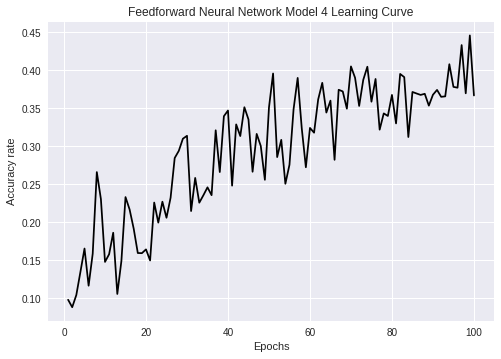

In [92]:
## =============================================================================
## Plot learning curve (accuracy rates vs. epoch index)
## =============================================================================
    
epochList = range(1, nEpochs+1)         #index epochs from 1 to number of epochs 



accuRatesVal = np.zeros((nEpochs))
    
for v in range(nEpochs):
  accuRatesVal[v] = accuRates[v]    #convert list to array

   
plt.figure(modelNbr)
    #plt.subplot(212)
    #plt.title('Validation data set fit')
plt.title('Feedforward Neural Network Model %d Learning Curve' %modelNbr)
plt.xlabel('Epochs')
plt.ylabel('Accuracy rate')
plt.plot( epochList , accuRatesVal ,  'k-')

plt.show()   
    


In [133]:
nTest = 10000

 
testPredList = []


for j in range(nTest): 
  # Manipulate data
  x = X_PTest[j]

  #x = sample[0]    # 1-D array
  #x = x.reshape(-1, 1)   # add one axis



  #yValid = sample[1]


  #        for n in range(10):
  #            yRaw[n] = int(yRaw[n])
  #        
  #        y = np.zeros(10)     # reset y to one-hot vector
  #        y = y.reshape(-1,1)   # 10-by-1
  #
  #                        
  #        y[yRaw] = 1  # converts sample to one-hot vector
  #    
  # Forward pass
  zH = np.dot( wH, x ) + bH          # calculate weighted input vector

  aH = actiFun(zH)      # calculate activation for hidden nodes

  zL = np.dot( wL, aH ) + bL

  aL = actiFun(zL)      # calculate activation for output nodes (which is also the prediction)

  # Make prediction
  digitPred = np.argmax(aL)     #Returns the index of the element with the highest value in the 10-size one-hot vector

  #        yRaw = np.nonzero(y)
  #        yRaw = yRaw[0]
  #        yRaw = yRaw[0]


  testPredList.append(digitPred)



        
        

    


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [131]:
print(sample.shape)


(1024, 1)


In [141]:
print(testPredList)

[7, 8, 0, 1, 6, 1, 8, 3, 8, 1, 8, 1, 1, 8, 0, 1, 8, 0, 0, 3, 3, 0, 0, 1, 8, 0, 8, 8, 1, 0, 1, 1, 4, 8, 8, 8, 0, 4, 8, 1, 4, 4, 8, 4, 0, 8, 8, 1, 8, 8, 8, 1, 3, 4, 3, 2, 3, 6, 8, 0, 8, 4, 3, 3, 8, 1, 3, 8, 8, 8, 1, 4, 8, 0, 8, 1, 1, 8, 8, 4, 8, 8, 1, 1, 3, 8, 8, 8, 1, 1, 3, 8, 0, 1, 1, 3, 7, 4, 1, 4, 4, 1, 8, 8, 4, 1, 3, 1, 6, 2, 1, 7, 8, 1, 4, 0, 8, 1, 8, 8, 8, 1, 8, 8, 4, 0, 8, 8, 0, 8, 8, 4, 3, 1, 8, 8, 1, 8, 0, 7, 8, 4, 0, 8, 1, 8, 8, 0, 8, 0, 1, 4, 4, 3, 8, 1, 8, 1, 8, 2, 8, 8, 3, 7, 8, 4, 0, 1, 6, 8, 3, 3, 2, 4, 8, 8, 3, 1, 4, 1, 6, 4, 4, 3, 2, 0, 4, 0, 1, 0, 2, 0, 7, 4, 3, 4, 4, 4, 3, 3, 8, 8, 8, 8, 0, 3, 8, 1, 3, 1, 4, 0, 8, 8, 7, 4, 3, 8, 4, 8, 8, 3, 8, 4, 1, 0, 8, 3, 8, 1, 0, 0, 8, 3, 2, 3, 1, 8, 1, 3, 8, 8, 1, 1, 4, 8, 8, 4, 6, 1, 4, 2, 0, 4, 3, 4, 8, 7, 4, 1, 7, 8, 7, 8, 8, 2, 3, 8, 8, 0, 4, 8, 1, 3, 1, 6, 7, 8, 3, 7, 1, 3, 3, 4, 8, 2, 4, 4, 1, 4, 7, 8, 1, 1, 8, 3, 3, 4, 8, 4, 3, 8, 3, 7, 3, 3, 1, 3, 1, 4, 0, 4, 1, 8, 3, 8, 3, 8, 8, 4, 0, 8, 7, 0, 1, 8, 8, 0, 8, 4, 8, 8, 3, 

In [140]:
# Print predictions for test dataset to file
  

import csv


testPredFile = open('FNN_TestPredFile_PreprocSigmoid1Layer.csv', 'a')  #append mode

wrt = csv.writer(testPredFile)
wrt.writerow(['Digit predicted by Feedforward network'])

for s in testPredList:
    testPredFile.write("%s\n" % s)
    
    
# how to get the file from Google colab? copy paste manually printout for now    
   
    
    
    
#from google.colab import files
#uploaded = files.upload()


# Download the file to a local disk as 'exported.xlsx'.
#downloaded.GetContentFile('FNN_TestPredFile_PreprocSigmoid1Layer.csv')



#uploaded['FNN_TestPredFile_PreprocSigmoid1Layer.csv']



KeyError: ignored